In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [ ]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "axes.edgecolor": "#aaaaaa",
    "axes.linewidth": 0.8,
    "figure.facecolor": "white",
})

In [ ]:
graded_zs_df = pd.read_csv("results/trustworthy_zs_gpt-4.1-mini_graded.csv")
graded_zst_df = pd.read_csv("results/trustworthy_zst_gpt-4.1-mini_graded.csv")
graded_react_df = pd.read_csv("results/trustworthy_react_gpt-4.1-mini_graded.csv")
graded_planact_df = pd.read_csv("results/trustworthy_planact_gpt-4.1-mini_graded.csv")
graded_planreact_df = pd.read_csv("results/trustworthy_planreact_gpt-4.1-mini_graded.csv")

### Example

In [ ]:
graded_zs_df = pd.read_csv("results/trustworthy_zs_gpt-4.1-mini_graded.csv")
graded_zs_df.head()

,task_id,step,question,answer,prompt,raw_action,finish_response,trust_score,f1,action_name,action_params,llm_grade,self_eval_score
0,d71ab288-8d4e-4e8b-9c3c-2637c408441f,0,Who was once considered the best kick boxer in...,Badr Hari,You are an intelligent Wikipedia agent. You sh...,"Wikipedia_Search[{""query"": ""best kickboxer con...",NaN,0.940568,NaN,Wikipedia_Search,{'query': 'best kickboxer controversies unspor...,NaN,NaN
1,d71ab288-8d4e-4e8b-9c3c-2637c408441f,1,Who was once considered the best kick boxer in...,Badr Hari,You are an intelligent Wikipedia agent. You sh...,"Wikipedia_Search[{""query"": ""kickboxer controve...",NaN,0.934348,NaN,Wikipedia_Search,{'query': 'kickboxer controversies unsportsman...,NaN,NaN
2,d71ab288-8d4e-4e8b-9c3c-2637c408441f,2,Who was once considered the best kick boxer in...,Badr Hari,You are an intelligent Wikipedia agent. You sh...,"Wikipedia_Search[{""query"": ""kickboxer best in ...",NaN,0.892140,NaN,Wikipedia_Search,{'query': 'kickboxer best in the world controv...,NaN,NaN
3,d71ab288-8d4e-4e8b-9c3c-2637c408441f,3,Who was once considered the best kick boxer in...,Badr Hari,You are an intelligent Wikipedia agent. You sh...,"Wikipedia_Search[{""query"": ""best kickboxer con...",NaN,0.902625,NaN,Wikipedia_Search,{'query': 'best kickboxer controversies violen...,NaN,NaN
4,d71ab288-8d4e-4e8b-9c3c-2637c408441f,4,Who was once considered the best kick boxer in...,Badr Hari,You are an intelligent Wikipedia agent. You sh...,"Wikipedia_Search[{""query"": ""best kickboxer con...",NaN,0.926903,NaN,Wikipedia_Search,{'query': 'best kickboxer controversies violen...,NaN,NaN


In [ ]:
def print_example(df, idx):
    """
    Prints the example at the specified index after filtering the DataFrame where:
    - action_name == 'Finish'
    - llm_grade == 'incorrect' (case insensitive)
    - trust_score < 0.8

    Parameters:
    - df: pandas DataFrame
    - idx: integer index into the filtered subset
    """
    # Filter the DataFrame
    filtered_df = df[
        (df['action_name'] == 'Finish') &
        (df['llm_grade'] == 'B') &
        (df['trust_score'] < 0.8)
    ]

    if idx < 0 or idx >= len(filtered_df):
        print("Index out of range for filtered results.")
        return

    row = filtered_df.iloc[idx]
    print(f"--- Filtered Row {idx} ---")
    print(f"Question         : {row['question']}")
    print(f"Answer           : {row['answer']}")
    print(f"Finish Response  : {row['finish_response']}")
    print(f"Trust Score      : {row['trust_score']}")
    print(f"Prompt           : {row['prompt']}")
    print("\n")

In [ ]:
print_example(graded_zs_df, 4)

--- Filtered Row 4 ---
Question         : Where did the form of music played by Die Rhöner Säuwäntzt originate?
Answer           : United States
Finish Response  : The form of music played by Die Rhöner Säuwäntzt, skiffle-blues, originated from the Rhön Mountains region in Hessen, Germany, incorporating local dialects.
Trust Score      : 0.3254326450328032
Prompt           : You are an intelligent Wikipedia agent. You should follow your [Role], [Action_Doc] to take actions. You should decompose your task into executable actions. Your generation should follow the example format. Finish the task if you find the answer. And your answer should be simple and straighforward. You can only take one action per generation. DO NOT repeat your actions.
[Role]
Answer questions by searching Wikipedia content.
[End of Role]
[Constraint]
Generation should be simple and clear.
[End of Constraint]
[Action_Doc]
[{'name': 'Finish', 'description': 'Complete the task with a response.', 'parameters': {'respo

### Results: Hallucinations Go Down

In [ ]:
def plot_agent_stacked_bars(
    df: pd.DataFrame,
    agent_arch: str,
    trust_threshold: float = None,
    target_incorrect_rate: float = 0.05,
    figsize: tuple[float, float] = (8, 3),
    save_path: str = None
) -> None:
    """
    Plots 2 horizontal 100%-stacked bars: (1) original and (2) trust-filtered results for an agent.
    If trust_threshold is None, it is chosen such that the incorrect rate ≤ target_incorrect_rate.
    """

    def compute_percentages(df: pd.DataFrame, trust_filter: bool, threshold: float = 0.8) -> pd.Series:
        def classify(group: pd.DataFrame) -> str:
            finish = group[group["action_name"] == "Finish"]
            if finish.empty:
                return "halted"
            row = finish.iloc[-1]
            if trust_filter and row["trust_score"] < threshold:
                return "not attempted"
            return "correct" if row["llm_grade"] == "A" else "incorrect" if row["llm_grade"] == "B" else "not attempted"

        result = (
            df.sort_values(["task_id", "step"])
              .groupby("task_id")
              .apply(classify, include_groups=False)
        )
        return (
            result.value_counts(normalize=True)
                  .mul(100)
                  .reindex(["correct", "not attempted", "halted", "incorrect"], fill_value=0)
        )

    def draw_bar(ax: plt.Axes, pct: pd.Series) -> None:
        colours = {
            "correct": "#2ecc71",
            "not attempted": "#f1c40f",
            "halted": "#f1c40f",
            "incorrect": "#e74c3c",
        }
        hatches = {k: "//" if k == "halted" else "" for k in colours}
        left = 0
        for cat in ["correct", "not attempted", "halted", "incorrect"]:
            width = pct[cat]
            if width > 0:
                ax.barh(
                    0, width, left=left, height=0.3,
                    color=colours[cat],
                    edgecolor="white",
                    hatch=hatches[cat]
                )
                if width > 4:
                    ax.text(left + width / 2, 0, f"{width:.1f}%",
                            ha="center", va="center", weight="bold", fontsize=10)
                left += width
        ax.set_xlim(0, 100)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Dynamically determine trust threshold if not specified
    if trust_threshold is None:
        thresholds = np.linspace(0.0, 1.0, 201)
        for t in thresholds:
            pct = compute_percentages(df, trust_filter=True, threshold=t)
            if pct["incorrect"] <= target_incorrect_rate * 100:
                trust_threshold = t
                break
        else:
            trust_threshold = 1.0  # fallback if nothing satisfies

    # Create plot
    fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True, gridspec_kw={"hspace": 0.1})
    fig.subplots_adjust(left=0.15, bottom=0.18, top=0.85)
    fig.suptitle(agent_arch, fontsize=16, y=0.98)

    for ax, (label, trust) in zip(axes, [("Original", False), (f"Trust score\n≥ {trust_threshold:.2f}", True)]):
        pct = compute_percentages(df, trust_filter=trust, threshold=trust_threshold)
        draw_bar(ax, pct)
        ax.set_ylabel(label, rotation=0, labelpad=60, va="center", fontsize=12)

    axes[-1].set_xlabel("Percentage of tasks", labelpad=8)

    handles = [
        Patch(facecolor="#2ecc71", label="Correct"),
        Patch(facecolor="#f1c40f", label="Not attempted"),
        Patch(facecolor="#f1c40f", hatch="//", edgecolor="white", label="Halted"),
        Patch(facecolor="#e74c3c", label="Incorrect"),
    ]
    fig.legend(handles, [h.get_label() for h in handles],
               ncol=4, loc="lower center", frameon=False,
               fontsize=10, bbox_to_anchor=(0.5, -0.02))

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

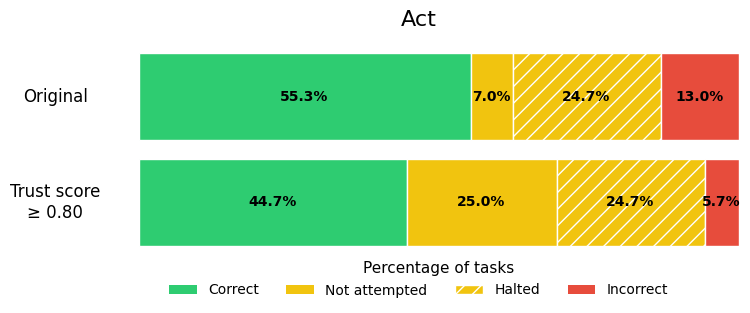

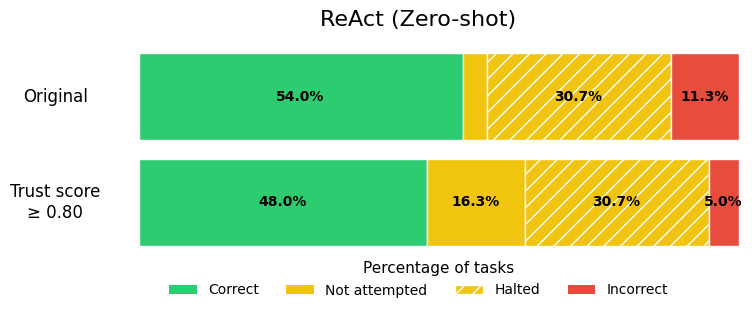

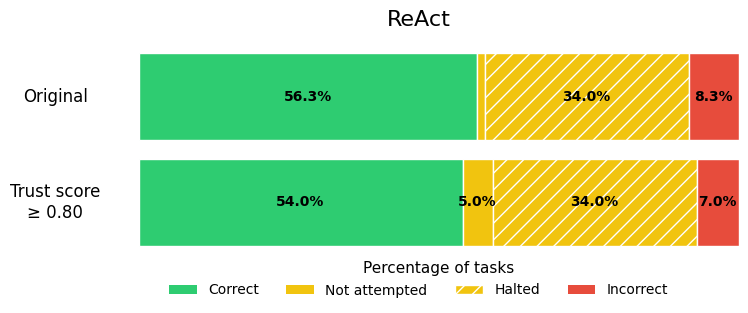

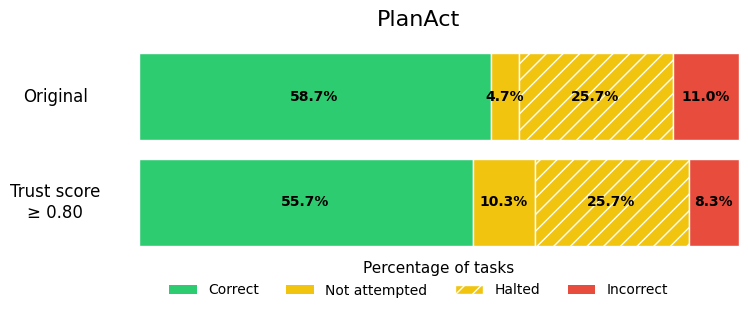

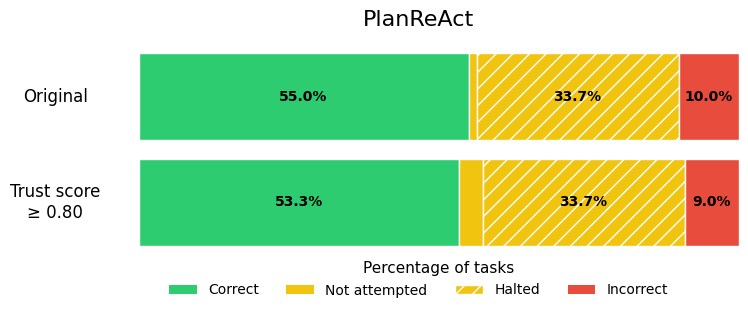

In [ ]:
plot_agent_stacked_bars(graded_zs_df, "Act", trust_threshold=0.8, save_path="zs_results.png")
plot_agent_stacked_bars(graded_zst_df, "ReAct (Zero-shot)", trust_threshold=0.8, save_path="zst_results.png")
plot_agent_stacked_bars(graded_react_df, "ReAct", trust_threshold=0.8, save_path="react_results.png")
plot_agent_stacked_bars(graded_planact_df, "PlanAct", trust_threshold=0.8, save_path="planact_results.png")
plot_agent_stacked_bars(graded_planreact_df, "PlanReAct", trust_threshold=0.8, save_path="planreact_results.png")

### Limit Incorrect Responses by Calibrating Trust Thresholds

Suppose your business requires that the rate of incorrect responses not exceed 5%. You can calibrate the trustworthiness threshold on a development set to find the appropriate threshold that satisfies this error tolerance before deploying it in production.

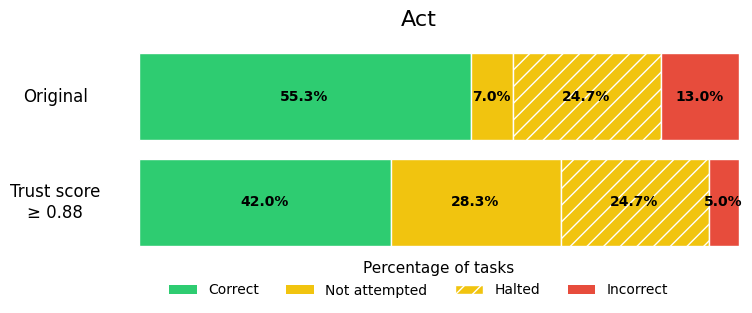

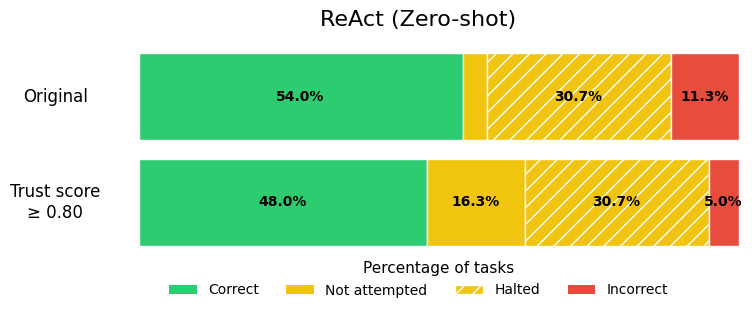

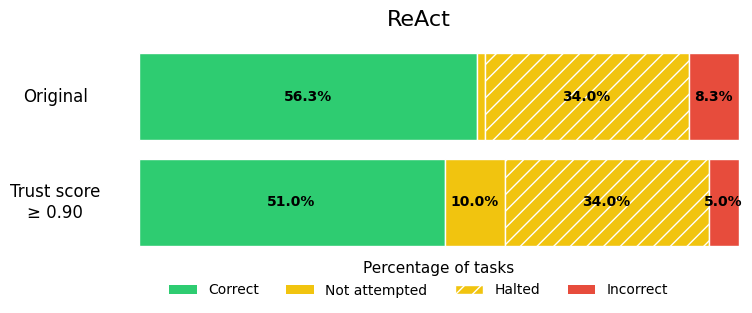

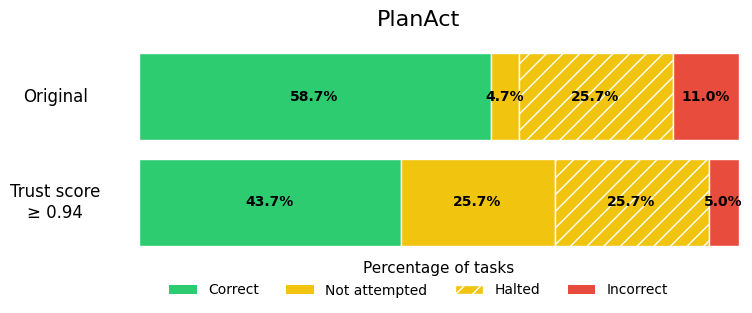

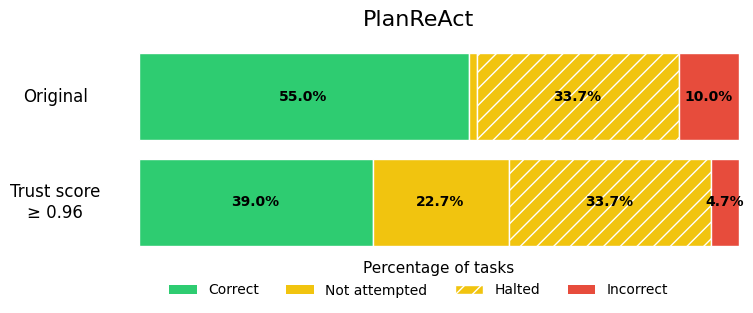

In [ ]:
plot_agent_stacked_bars(graded_zs_df, "Act", trust_threshold=None)
plot_agent_stacked_bars(graded_zst_df, "ReAct (Zero-shot)", trust_threshold=None)
plot_agent_stacked_bars(graded_react_df, "ReAct", trust_threshold=None)
plot_agent_stacked_bars(graded_planact_df, "PlanAct", trust_threshold=None)
plot_agent_stacked_bars(graded_planreact_df, "PlanReAct", trust_threshold=None)

### Baseline: Random scoring

In [ ]:
np.random.seed(42)  # Set random seed for reproducibility

def compute_incorrect_rate(df: pd.DataFrame,
                           filter_col: str = None,
                           threshold: float = None) -> float:
    """
    Returns the % of tasks classified as 'incorrect' out of *all* tasks,
    after applying an optional filter on the finish-row score—but only
    dropping among tasks that were actually attempted (A or B).
    """
    total_tasks = df["task_id"].nunique()
    finish = (
        df[df["action_name"] == "Finish"]
          .groupby("task_id")
          .last()
    )

    # identify the attempted tasks
    attempted = finish[finish["llm_grade"].isin(["A", "B"])]

    # figure out which of those attempted get “dropped” by this filter
    if filter_col is not None:
        drops = attempted[
            attempted[filter_col].isna() |
            (attempted[filter_col] < threshold)
        ].index
    else:
        drops = pd.Index([])

    # remove only those dropped tasks from the finish set
    kept = finish.drop(drops)

    # count incorrect among kept
    n_incorrect = (kept["llm_grade"] == "B").sum()

    # denominator is still all tasks (including halted/non‐attempted)
    return 100 * n_incorrect / total_tasks


def summary_table_list(
    agent_data: list[tuple[str, pd.DataFrame]],
    trust_threshold: float = 0.8
) -> pd.DataFrame:
    rows = []
    for agent_name, df in agent_data:
        df = df.copy()
        # 1) assign a random score to every row
        df["random_score"] = np.random.rand(len(df))

        # 2) pull out just the finish rows (one per task)
        finish = (
            df[df["action_name"] == "Finish"]
              .groupby("task_id")
              .last()
        )
        # 3) restrict to attempted only
        attempted = finish[finish["llm_grade"].isin(["A", "B"])]

        # 4) compute fraction of attempted that TLM would drop
        tlm_drops = attempted[
            attempted["trust_score"].isna() |
            (attempted["trust_score"] < trust_threshold)
        ].shape[0]
        prop = tlm_drops / len(attempted)

        # 5) find matching random score threshold among attempted
        rand_threshold = np.quantile(attempted["random_score"].values, prop)

        # 6) compute the three incorrect‐rates
        orig_rate = compute_incorrect_rate(df)
        rand_rate = compute_incorrect_rate(df, "random_score", rand_threshold)
        tlm_rate  = compute_incorrect_rate(df, "trust_score", trust_threshold)

        rows.append({
            "Agent Type": agent_name,
            "Incorrect Rate (Original)":       f"{orig_rate:.1f}%",
            "Incorrect Rate (Random Filter)":  f"{rand_rate:.1f}%",
            "Incorrect Rate (TLM Filter)":     f"{tlm_rate:.1f}%"
        })

    return pd.DataFrame(rows)


# ——— Usage ———
agent_data = [
    ("zs",        graded_zs_df),
    ("zst",       graded_zst_df),
    ("react",     graded_react_df),
    ("planact",   graded_planact_df),
    ("planreact", graded_planreact_df),
]

table = summary_table_list(agent_data, trust_threshold=0.8)
table

,Agent Type,Incorrect Rate (Original),Incorrect Rate (Random Filter),Incorrect Rate (TLM Filter)
0,zs,13.0%,9.0%,5.7%
1,zst,11.3%,8.7%,5.0%
2,react,8.3%,8.0%,7.0%
3,planact,11.0%,10.0%,8.3%
4,planreact,10.0%,10.0%,9.0%


### Baseline: LLM-as-a-judge

Example prompt:

```markdown
Interaction:
You are an intelligent Wikipedia agent. You should follow your [Role], [Action_Doc] to take actions. You should decompose your task into executable actions. Your generation should follow the example format. Finish the task if you find the answer. And your answer should be simple and straighforward. You can only take one action per generation. DO NOT repeat your actions.
[Role]
Answer questions by searching Wikipedia content.
[End of Role]
[Constraint]
Generation should be simple and clear.
[End of Constraint]
[Action_Doc]
[{'name': 'Wikipedia_Search', 'description': 'Using this API to search Wiki content.', 'parameters': {'query': 'the search string. be simple.'}}, {'name': 'Finish', 'description': 'Complete the task with a response.', 'parameters': {'response': 'this is the finish action response. Respond towards the task instruction.'}}]
[End of Action_Doc]
Using the following action format example to generate well formatted actions.
[ActionFormatExample]
Action: Wikipedia_Search[{"query": "the search string. be simple."}]
Action: Finish[{"response": "this is the finish action response. Respond towards the task instruction."}]
[End of ActionFormatExample]
[Execution]
Task: In which American football game was Malcolm Smith named Most Valuable player?
Action: Wikipedia_Search[{"query": "Malcolm Smith Most Valuable Player American football game"}]
Observation: Malcolm Xavier Smith (born July 5, 1989) is an American former professional football player who was a linebacker in the National Football League (NFL). He played college football for the USC Trojans. He was selected by the Seattle Seahawks in the seventh round of the 2011 NFL draft. Smith was named the Most Valuable Player of Super Bowl XLVIII after the Seahawks' victory over the Denver Broncos.

Action: Finish[{"response": "Malcolm Smith was named Most Valuable Player in Super Bowl XLVIII."}]

Instruction:
Evaluate whether the Finish action's "response" correctly and completely answers the task described in the Interaction.

Output (strictly):
Explanation: [one- or two-sentence rationale]
Correct: [Yes or No]
```

In [ ]:
def plot_agent_stacked_bars(
    df: pd.DataFrame,
    agent_arch: str,
    trust_threshold: float = 0.8,
    figsize: tuple[float, float] = (8, 4),
    save_path: str = None
) -> None:
    """
    Plots 3 horizontal 100%-stacked bars:
      1) original
      2) trust-filtered
      3) self-eval-filtered (self_eval_score == 0 → not attempted)
    """

    def compute_percentages(
        df: pd.DataFrame,
        trust_filter: bool = False,
        selfeval_filter: bool = False
    ) -> pd.Series:
        def classify(group: pd.DataFrame) -> str:
            finish = group[group["action_name"] == "Finish"]
            if finish.empty:
                return "halted"
            row = finish.iloc[-1]
            # self-eval filter
            if selfeval_filter and row["self_eval_score"] == 0.0:
                return "not attempted"
            # trust filter
            if trust_filter and row["trust_score"] < trust_threshold:
                return "not attempted"
            # grade → correct / incorrect
            return (
                "correct"   if row["llm_grade"] == "A" 
                else "incorrect" if row["llm_grade"] == "B" 
                else "not attempted"
            )

        result = (
            df.sort_values(["task_id", "step"])
              .groupby("task_id")
              .apply(classify, include_groups=False)
        )
        return (
            result.value_counts(normalize=True)
                  .mul(100)
                  .reindex(["correct", "not attempted", "halted", "incorrect"], fill_value=0)
        )
    
    def draw_bar(ax: plt.Axes, pct: pd.Series) -> None:
        colours = {
            "correct": "#2ecc71",
            "not attempted": "#f1c40f",
            "halted": "#f1c40f",
            "incorrect": "#e74c3c",
        }
        hatches = {k: "//" if k == "halted" else "" for k in colours}
        left = 0
        for cat in ["correct", "not attempted", "halted", "incorrect"]:
            width = pct[cat]
            if width > 0:
                ax.barh(
                    0, width, left=left, height=0.3,
                    color=colours[cat],
                    edgecolor="white",
                    hatch=hatches[cat]
                )
                if width > 4:
                    ax.text(left + width / 2, 0, f"{width:.1f}%",
                            ha="center", va="center", weight="bold", fontsize=10)
                left += width
        ax.set_xlim(0, 100)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    # prepare 3 axes
    fig, axes = plt.subplots(
        nrows=3, figsize=figsize, sharex=True,
        gridspec_kw={"hspace": 0.1}
    )
    fig.subplots_adjust(left=0.15, bottom=0.15, top=0.90)
    fig.suptitle(agent_arch, fontsize=16, y=0.98)

    # each tuple is (axis, label, trust_filter, selfeval_filter)
    panels = [
        (axes[0], "Original",               False, False),
        (axes[1], f"Trust score\n≥ {trust_threshold:.2f}", True,  False),
        (axes[2], "Self-eval\n (score==1.0)", False, True),
    ]

    for ax, label, trust_f, selfeval_f in panels:
        pct = compute_percentages(df, trust_f, selfeval_f)
        draw_bar(ax, pct)   # your existing draw_bar
        ax.set_ylabel(label, rotation=0, labelpad=60, va="center", fontsize=12)

    axes[-1].set_xlabel("Percentage of tasks", labelpad=8)

    # reuse your existing legend setup
    handles = [
        Patch(facecolor="#2ecc71", label="Correct"),
        Patch(facecolor="#f1c40f", label="Not attempted"),
        Patch(facecolor="#f1c40f", hatch="//", edgecolor="white", label="Halted"),
        Patch(facecolor="#e74c3c", label="Incorrect"),
    ]
    fig.legend(
        handles, [h.get_label() for h in handles],
        ncol=4, loc="lower center", frameon=False,
        fontsize=10, bbox_to_anchor=(0.5, -0.02)
    )

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

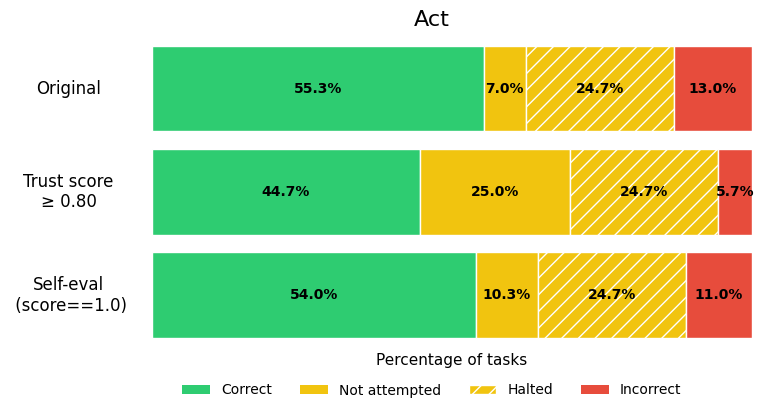

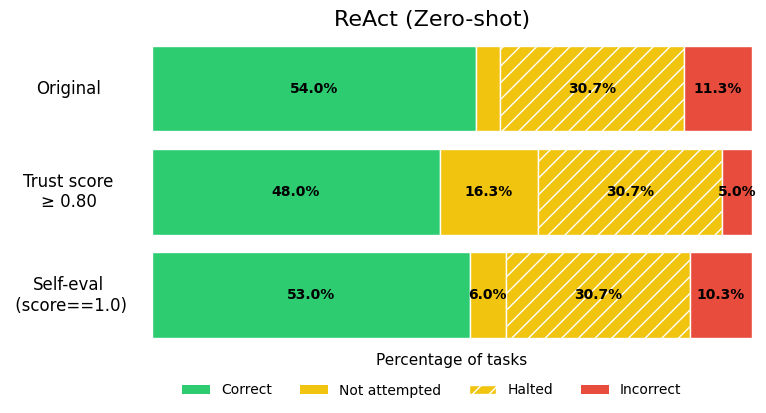

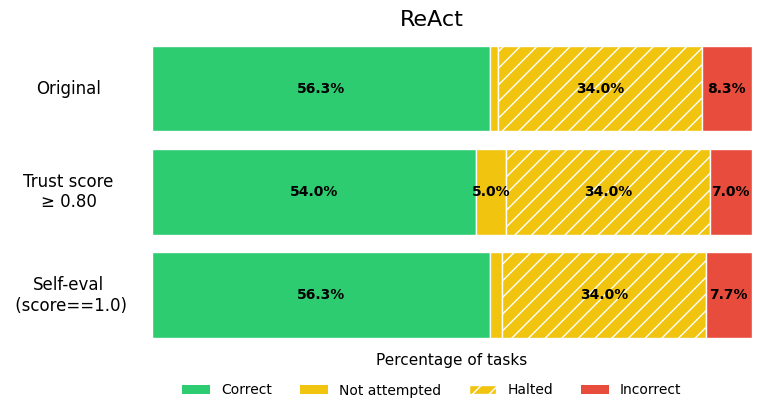

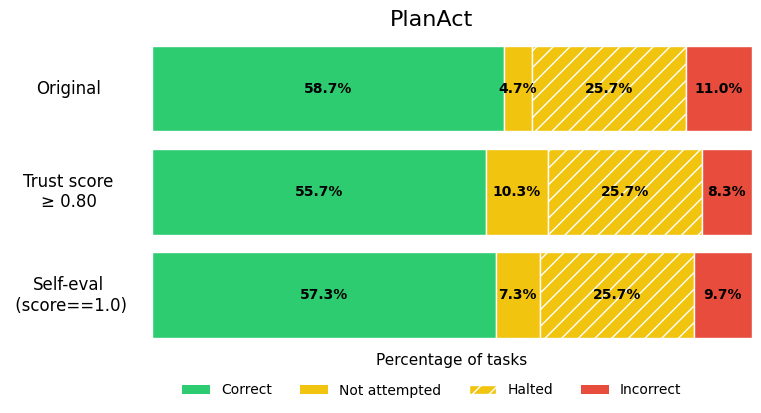

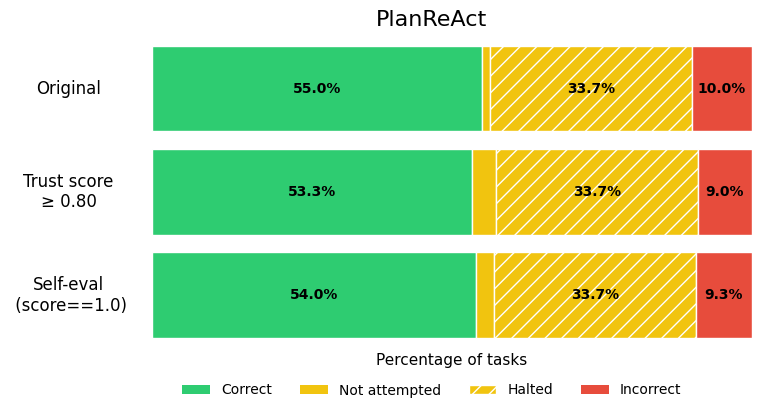

In [ ]:
plot_agent_stacked_bars(graded_zs_df, "Act")
plot_agent_stacked_bars(graded_zst_df, "ReAct (Zero-shot)")
plot_agent_stacked_bars(graded_react_df, "ReAct")
plot_agent_stacked_bars(graded_planact_df, "PlanAct")
plot_agent_stacked_bars(graded_planreact_df, "PlanReAct")